<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/Temperature_Forecasting(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It's my first project on time series task, all the code I will take from the book: 'Deep learning with python' François Chollet. However I will change it a little, but it's core structure will preserve

The dataset I am going to use is The Jena Climate Dataset. A comprehensive weather time series recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany, spanning from 2009 to 2016. This dataset includes 14 distinct meteorological variables, each measured every 10 minutes, providing detailed insights into the local climate over several years.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
# Get the data and unzip it
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-01-27 15:43:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.38, 52.216.76.182, 16.182.69.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.80MB/s    in 1.9s    

2025-01-27 15:43:19 (6.80 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
header = [col for col in header if col not in ['"Tpot (K)"', '"Tdew (degC)"']]
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

In [5]:
df = pd.read_csv(fname)

df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")




Date Time: Timestamp of the observation.

p (mbar): Atmospheric pressure in millibars.

T (°C): Temperature in degrees Celsius.

Tpot (K): Potential temperature in Kelvin.

Tdew (°C): Dew point temperature in degrees Celsius.

rh (%): Relative humidity percentage.

VPmax (mbar): Maximum vapor pressure.

VPact (mbar): Actual vapor pressure.

VPdef (mbar): Vapor pressure deficit.

sh (g/kg): Specific humidity in grams per kilogram.

H2OC (mmol/mol): Water vapor concentration.

rho (g/m³): Air density in grams per cubic meter.

wv (m/s): Wind speed in meters per second.

max. wv (m/s): Maximum wind speed in meters per second.

wd (deg): Wind direction in degrees.

# Divide the data into 2 numpy arrays:
Temperature data I am going to store column 1 in 'temperature'

And all columns including temeprature in 'raw_data'

In [6]:
temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, value in enumerate(lines):
  values = [float(x) for x in value.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:1] + values[3:] # skip removed Tpot and Tdew

In [7]:
print(raw_data.shape)
print(temperature.shape)

(420451, 12)
(420451,)


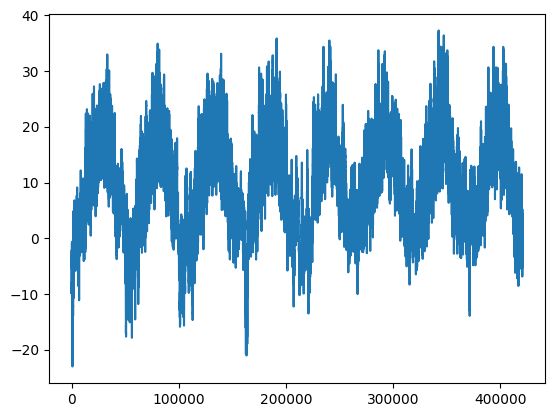

In [8]:
plt.plot(range(len(temperature)), temperature);

This is more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, we get 24 x 6 = 144 data points per day

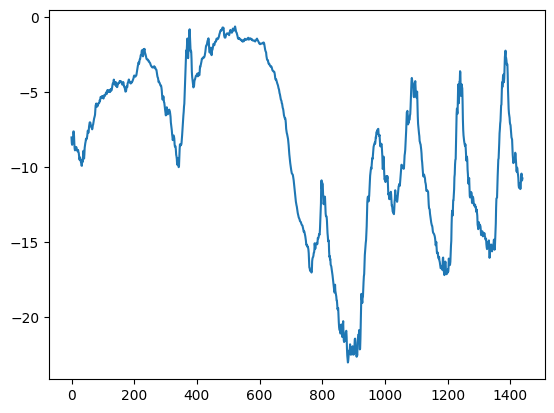

In [9]:
plt.plot(range(1440), temperature[:1440]);

##Feature Preprocessing

When working with timeseries data, it's important to use more validation and test data, because you're trying to predict the future given the past, not the reverse. And your validation and test splits should reflect that.

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_valid_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_valid_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

print('Num_Train_Samples', num_train_samples)
print('Num_Valid_Samples', num_valid_samples)
print('Num_Test_Samples', num_test_samples)

Num_Train_Samples 210225
Num_Valid_Samples 105112
Num_Test_Samples 105114


In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_test_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_valid_samples
)


Each dataset yields a tuple (samples, targets)

In [12]:
for samples, targets in train_dataset:
  print('train samples: ', samples.shape)
  print('train targets:', targets.shape)
  break

train samples:  (256, 120, 12)
train targets: (256,)


256 sequences, each sequence contains 120 sampled data points(time steps) and 14 is the number of features in each time step

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3, return_sequences=True))(inputs)
#x = layers.BatchNormalization()(x)
x = layers.Bidirectional(layers.LSTM(128, recurrent_dropout=0.3, return_sequences=True))(x)
#x = layers.BatchNormalization()(x)
x = layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.3, return_sequences=False))(x)
#x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                             save_best_only=True)

]
epochs=20
num_train_steps = len(train_dataset) * epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler), loss='mse', metrics=[RootMeanSquaredError()])

In [14]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - loss: 21.2128 - root_mean_squared_error: 4.4356 - val_loss: 9.0975 - val_root_mean_squared_error: 3.0162
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 992s 1s/step - loss: 7.9857 - root_mean_squared_error: 2.8248 - val_loss: 9.9951 - val_root_mean_squared_error: 3.1615
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 961s 1s/step - loss: 5.3521 - root_mean_squared_error: 2.3123 - val_loss: 11.4750 - val_root_mean_squared_error: 3.3875
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 971s 1s/step - loss: 3.4033 - root_mean_squared_error: 1.8439 - val_loss: 11.8993 - val_root_mean_squared_error: 3.4495
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 962s 1s/step - loss: 2.3279 - root_mean_squared_error: 1.5252 - val_loss: 11.7066 - val_root_mean_squared_error: 3.4215
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 984s 1s/step - loss: 1.7230 - root_mean_squared_error: 1.3123 - val_loss: 12.1312 - val_root_mean_squared_error: 3.4830
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 9

In [15]:
model.save('lstm_temperature.h5')

# load model
new_model = tf.keras.models.load_model('lstm_temperature.h5')

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

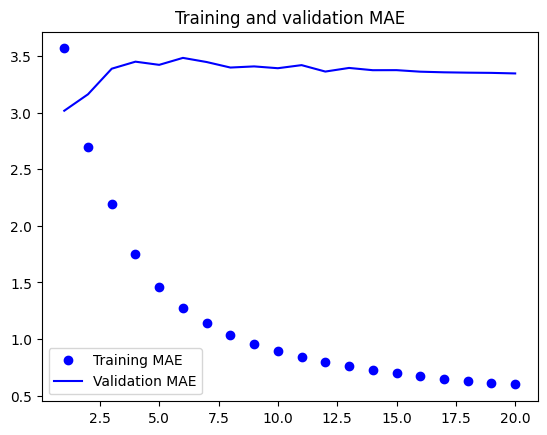

In [17]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We have 420451 data points

In [ ]:
X_train = raw_data[:num_train_samples]
y_train = temperature[delay:num_train_samples + delay]

X_valid = raw_data[num_train_samples: num_train_samples + num_valid_samples]
y_valid = temperature[num_train_samples + delay: num_train_samples + num_valid_samples + delay]

X_test = raw_data[num_train_samples + num_valid_samples:num_train_samples + num_valid_samples + num_test_samples]
y_test = temperature[num_train_samples + num_valid_samples + delay:num_train_samples + num_valid_samples + num_test_samples + delay]

In [ ]:
dtrain = xgb.Dmatrix(X_train, label=y_train)
dval = xgb.Dmatrix(X_valid, label=y_valid)
dtest = xgb.Dmatrix(X_test, label=y_test)

In [ ]:
import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

watchlist = [(dtest, 'test'), (dval, 'valid')]

evals_result = {}

num_rounds = 100
xgb_model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals = watchlist,
    evals_result = evals_result,
    early_stopping_rounds = 10
)y

train_rmse = evals_result['train']['rmse']
valid_rmse = evals_result['valid']['rmse']

In [ ]:
epochs = range(1, len(xgb_model) + 1)
plt.figure()
plt.plot(epochs, train_rmse, 'bo', label='Training RMSE')
plt.plot(epochs, valid_rmse, 'b', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.plot()